In [138]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [139]:
df = pd.read_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\jup_lab\movies_2004_2023_cleaned.csv')

### Low budget

In [140]:
genres = ['action','adventure','animated','biographical','black','buddy','comedy',
 'comedy-drama','crime','drama','epic','fantasy','fiction','historical','horror','musical',
 'psychological','romantic','science','sports','superhero','supernatural','thriller','war']

In [141]:
budget_group = df['Budget group']

<Axes: >

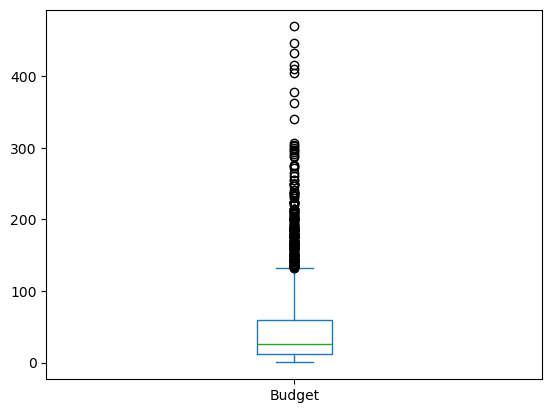

In [142]:
df['Budget'].plot.box()

I'll delete the movies with a too high profit perc. Their success is amazing and hard to replicate.

In [143]:
def get_limits(df):
    print('llimit', str(df.quantile(0.25) - 1.5*(df.quantile(0.75) - df.quantile(0.25))))
    print('ulimit', str(df.quantile(0.75) + 1.5*(df.quantile(0.75) - df.quantile(0.25))))
    print('Extreme llimit', str(df.quantile(0.25) - 3*(df.quantile(0.75) - df.quantile(0.25))))
    print('Extreme ulimit', str(df.quantile(0.75) + 3*(df.quantile(0.75) - df.quantile(0.25))))

#### Handling the outliers of Profit perc in low df

In [144]:
get_limits(df.loc[budget_group == 'low', 'Profit perc'])

llimit -639.947915
ulimit 937.468749
Extreme llimit -1231.479164
Extreme ulimit 1528.999998


In [145]:
(df.loc[budget_group == 'low', 'Profit perc'] > 938).sum()

103

In [146]:
low_df = df.loc[(budget_group == 'low') & (df['Profit perc'] < 938)]
low_df.shape

(1104, 33)

In [147]:
def profit_genre(df, genres, col):
    for i in genres:
        if df[i] == 1:
            df[i] = df[col]
    return df

#### I grab the genres that have at least 15 occurrences

In [148]:
low_df[genres].sum(axis=0)

action           72.0000
adventure        17.0000
animated         12.0000
biographical     62.0000
black            41.0000
buddy            13.0000
comedy          256.0000
comedy-drama    148.0000
crime            63.0000
drama           320.0000
epic              9.0000
fantasy          21.0000
fiction          41.0000
historical       15.0000
horror          139.0000
musical          19.0000
psychological    53.0000
romantic        134.0000
science          43.0000
sports           24.0000
superhero         7.0000
supernatural     52.0000
thriller        132.0000
war              18.0000
dtype: float64

# Start analysis

In [149]:
low_genres = low_df[genres].sum(axis=0).loc[low_df[genres].sum(axis=0) > 15].index.tolist()
print(low_genres)

['action', 'adventure', 'biographical', 'black', 'comedy', 'comedy-drama', 'crime', 'drama', 'fantasy', 'fiction', 'horror', 'musical', 'psychological', 'romantic', 'science', 'sports', 'supernatural', 'thriller', 'war']


In [150]:
low_df_profit_perc = low_df[low_genres+ ['Profit perc']].apply(profit_genre, genres=low_genres,
                                     col='Profit perc', axis=1)

low_df_profit_perc[low_df_profit_perc == 0] = np.nan

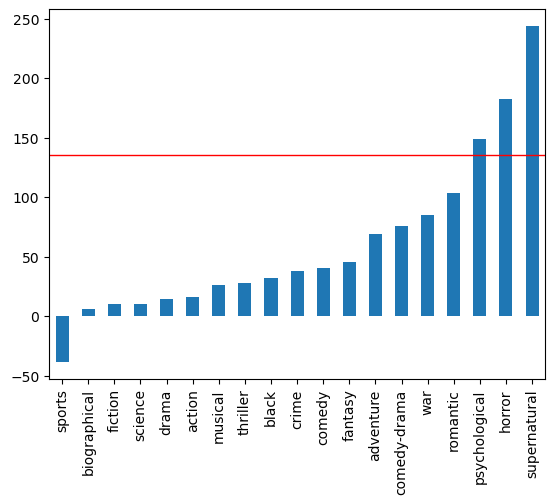

In [151]:
ax = low_df_profit_perc.drop(columns='Profit perc').median(axis=0).sort_values().plot.bar()
ax.hlines(y=low_df_profit_perc['Profit perc'].mean(),
          xmin=-1, xmax=70,
          linewidth=1, color='r');

As we can see some genres have a very different mean from the mean of the whole group. Yet, it's too early to speak. We have to make sure that this is not something produced by chance alone.

In [152]:
pd.set_option('display.float_format',  '{:.4f}'.format)

from scipy.stats import pearsonr

pearsonr_df_stat= []
pearsonr_df_pv= []
pearsonr_id = []

for genre in low_genres:
    values = pearsonr(low_df[genre], low_df['Profit perc'])
    pearsonr_df_stat.append(values[0])
    pearsonr_df_pv.append(values[1])
    pearsonr_id.append(genre)


pearsonr_df = pd.DataFrame(index=pearsonr_id, data={'Correlation coef.':pearsonr_df_stat,
            'P-value':pearsonr_df_pv}).sort_values('P-value')
pearsonr_df

,Correlation coef.,P-value
supernatural,0.1586,0.0000
horror,0.1564,0.0000
psychological,0.0767,0.0108
drama,-0.0702,0.0196
sports,-0.0664,0.0275
biographical,-0.0649,0.0312
action,-0.0513,0.0883
musical,-0.0432,0.1512
romantic,0.0428,0.1551
thriller,-0.0342,0.2563


The only genres we can trust are the ones with a P-value < 0.05

In [153]:
pearsonr_df[pearsonr_df['P-value'] < 0.05]

,Correlation coef.,P-value
supernatural,0.1586,0.0000
horror,0.1564,0.0000
psychological,0.0767,0.0108
drama,-0.0702,0.0196
sports,-0.0664,0.0275
biographical,-0.0649,0.0312


In [154]:
low_genres_trust = pearsonr_df[pearsonr_df['P-value'] < 0.05].index.tolist()

I take that a step further. I wanna be more confident that these genres do indeed influece that Profit %... and it's not by chance.

So I use bootstrapping and confidence intervals.

In [155]:
from scipy.stats import bootstrap

def get_conf_df(df,genres, my_func):
    conf_df_id = []
    conf_df_low = []
    conf_df_high = []

    for genre in genres:
        df_to_test = (df[genre].dropna(),)
        bootstrap_ci = bootstrap(df_to_test,
                                my_func,
                                n_resamples=1999,
                                confidence_level=0.95,
                                random_state=1)

        conf_df_id.append(genre)
        conf_df_high.append(bootstrap_ci.confidence_interval[1])
        conf_df_low.append(bootstrap_ci.confidence_interval[0])
    
    return conf_df_id, conf_df_low, conf_df_high

mean_conf = get_conf_df(low_df_profit_perc,['Profit perc'] +low_genres_trust, np.median)

conf_df = pd.DataFrame(index=mean_conf[0], data={'Low band':mean_conf[1],
            'High band':mean_conf[2]})
conf_df

,Low band,High band
Profit perc,30.0000,69.4444
supernatural,179.5000,385.2365
horror,118.8235,246.3848
psychological,54.2857,254.6562
drama,-1.3204,43.6667
sports,-55.0000,12.5660
biographical,-50.0000,50.6250


These are the genres that don't overlap at 95% conficende level. We can trust that these genres do actually influence the profit % of a low budget movie.

In [156]:
mask1 = conf_df.loc[:,'Low band'] > conf_df.loc['Profit perc', 'High band']
mask2 = conf_df.loc[:,'High band'] < conf_df.loc['Profit perc', 'Low band']

low_genres_trust = conf_df[(mask1 | mask2)].index.tolist()
conf_df[(mask1 | mask2)]


,Low band,High band
supernatural,179.5000,385.2365
horror,118.8235,246.3848
sports,-55.0000,12.5660


c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

<Axes: >

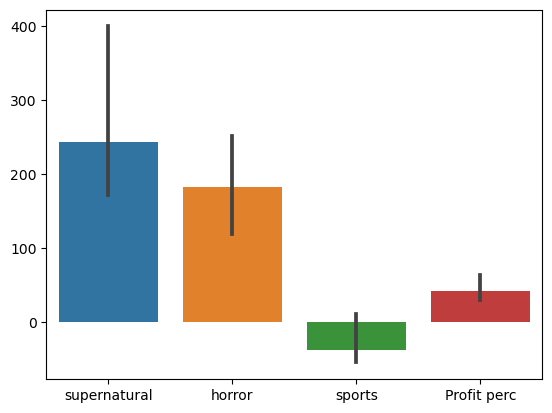

In [157]:
sns.barplot(data=low_df_profit_perc[low_genres_trust + ['Profit perc']], estimator='median',
            errorbar='ci')

In [158]:
def my_q1(x):
    return np.quantile(a=x, q=0.25)

q1_conf = get_conf_df(low_df_profit_perc, low_genres_trust + ['Profit perc'], my_q1)

c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


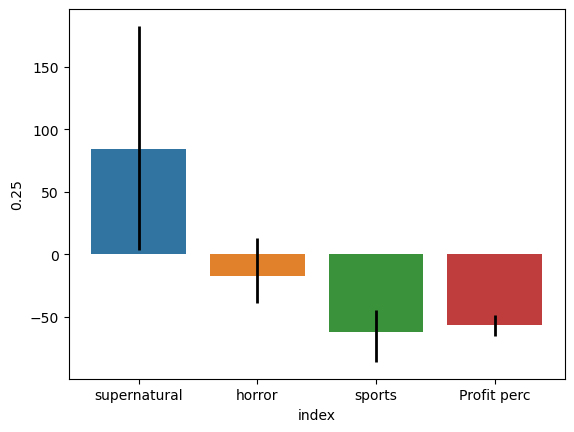

In [159]:
ax = sns.barplot(data=low_df_profit_perc[low_genres_trust + ['Profit perc']].quantile(0.25).to_frame().reset_index(),
            errorbar=None, x='index', y=0.25)

for n in range(len(q1_conf[0])):
    ax.vlines(x=n,
            ymin=q1_conf[1][n], ymax=q1_conf[2][n],
            linewidth=2, color='black');

#### I check to see if the confidence interval for the q3 overlap. I didn't do this for the q1 because there's a limit to how bad a movie can do.

In [160]:
#I have to use 0.751 and not 0.75 because 0.75 gives me a Runtime error.

def my_q3(x):
    return np.quantile(a=x, q=0.751)

q3_conf = get_conf_df(low_df_profit_perc, low_genres_trust + ['Profit perc'], my_q3)

In [161]:
q3_conf_df = pd.DataFrame(index=q3_conf[0], data={'Low band':q3_conf[1],
            'High band':q3_conf[2]})

mask1 = q3_conf_df.loc[:,'Low band'] > q3_conf_df.loc['Profit perc', 'High band']
mask2 = q3_conf_df.loc[:,'High band'] < q3_conf_df.loc['Profit perc', 'Low band']

q3_conf_df[(mask1 | mask2)]

,Low band,High band
supernatural,390.1562,678.0952
horror,327.7778,527.7372
sports,-28.3007,168.8235


c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


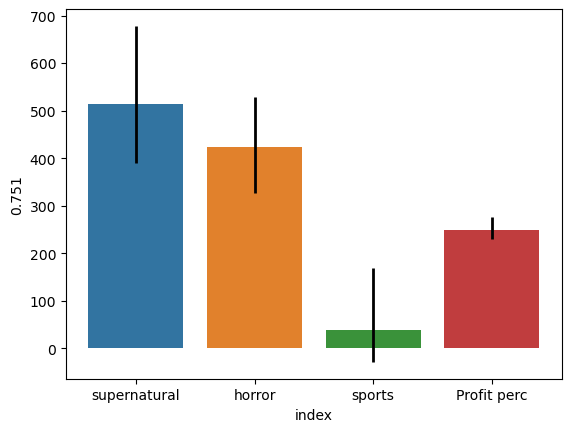

In [162]:
ax = sns.barplot(data=low_df_profit_perc[low_genres_trust + ['Profit perc']].quantile(0.751).to_frame().reset_index(),
            errorbar=None, x='index', y=0.751)

for n in range(len(q3_conf[0])):
    ax.vlines(x=n,
            ymin=q3_conf[1][n], ymax=q3_conf[2][n],
            linewidth=2, color='black');

## Mid Budget

#### Handling the outliers in Profit perc in mid budget

In [163]:
get_limits(df.loc[budget_group == 'mid', 'Profit perc'])

llimit -335.342105
ulimit 539.6052629999999
Extreme llimit -663.447368
Extreme ulimit 867.710526


In [164]:
(df.loc[budget_group == 'mid', 'Profit perc'] > 539).sum()

81

In [165]:
mid_df = df.loc[(budget_group == 'mid') & (df['Profit perc'] < 539)]
mid_df.shape

(1192, 33)

#### Grab the genres with at least 15 occurrences

In [166]:
mid_genres = mid_df[genres].sum(axis=0).loc[mid_df[genres].sum(axis=0) > 15].index.tolist()
print(mid_genres)

['action', 'adventure', 'animated', 'biographical', 'black', 'buddy', 'comedy', 'comedy-drama', 'crime', 'drama', 'epic', 'fantasy', 'fiction', 'historical', 'horror', 'musical', 'psychological', 'romantic', 'science', 'sports', 'superhero', 'supernatural', 'thriller', 'war']


In [167]:
mid_df_profit_perc = mid_df[mid_genres+ ['Profit perc']].apply(profit_genre, genres=mid_genres,
                                     col='Profit perc', axis=1)

mid_df_profit_perc[mid_df_profit_perc == 0] = np.nan

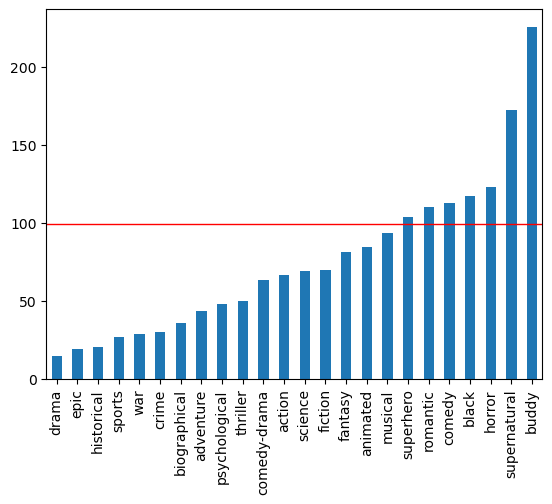

In [168]:
ax = mid_df_profit_perc.drop(columns='Profit perc').median(axis=0).sort_values().plot.bar()
ax.hlines(y=mid_df_profit_perc['Profit perc'].mean(),
          xmin=-1, xmax=70,
          linewidth=1, color='r');

#### P-value and correlation

In [169]:
mid_pearsonr_df_stat= []
mid_pearsonr_df_pv= []
mid_pearsonr_id = []

for genre in mid_genres:
    values = pearsonr(mid_df[genre], mid_df['Profit perc'])
    mid_pearsonr_df_stat.append(values[0])
    mid_pearsonr_df_pv.append(values[1])
    mid_pearsonr_id.append(genre)


mid_pearsonr_df = pd.DataFrame(index=mid_pearsonr_id, data={'Correlation coef.':mid_pearsonr_df_stat,
            'P-value':mid_pearsonr_df_pv}).sort_values('P-value')
mid_pearsonr_df

,Correlation coef.,P-value
comedy,0.1651,0.0000
drama,-0.1384,0.0000
buddy,0.1355,0.0000
supernatural,0.1122,0.0001
romantic,0.0719,0.0130
animated,0.0577,0.0465
horror,0.0534,0.0652
sports,-0.0526,0.0697
biographical,-0.0465,0.1083
musical,0.0462,0.1111


In [170]:
mid_pearsonr_df[mid_pearsonr_df['P-value'] < 0.05]

,Correlation coef.,P-value
comedy,0.1651,0.0000
drama,-0.1384,0.0000
buddy,0.1355,0.0000
supernatural,0.1122,0.0001
romantic,0.0719,0.0130
animated,0.0577,0.0465


In [171]:
mid_genres_trust = mid_pearsonr_df[mid_pearsonr_df['P-value'] < 0.05].index.tolist()

#### Confidence interval

In [172]:
mid_mean_conf = get_conf_df(mid_df_profit_perc,['Profit perc'] +mid_genres_trust, np.median)

mid_conf_df = pd.DataFrame(index=mid_mean_conf[0], data={'Low band':mid_mean_conf[1],
            'High band':mid_mean_conf[2]})
mid_conf_df

,Low band,High band
Profit perc,62.6500,85.2667
comedy,94.0000,130.7750
drama,-4.5455,36.7070
buddy,125.1111,303.3687
supernatural,128.6225,228.0000
romantic,71.7143,141.1429
animated,56.9477,147.0727


In [173]:
mask1 = mid_conf_df.loc[:,'Low band'] > mid_conf_df.loc['Profit perc', 'High band']
mask2 = mid_conf_df.loc[:,'High band'] < mid_conf_df.loc['Profit perc', 'Low band']

mid_genres_trust = mid_conf_df[(mask1 | mask2)].index.tolist()
mid_conf_df[(mask1 | mask2)]

,Low band,High band
comedy,94.0000,130.7750
drama,-4.5455,36.7070
buddy,125.1111,303.3687
supernatural,128.6225,228.0000


c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

<Axes: >

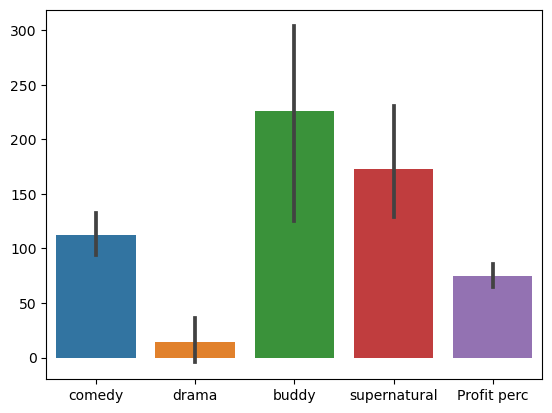

In [174]:
sns.barplot(data=mid_df_profit_perc[mid_genres_trust + ['Profit perc']], estimator='median',
            errorbar='ci')

In [175]:
mid_q1_conf = get_conf_df(mid_df_profit_perc, mid_genres_trust + ['Profit perc'], my_q1)

c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


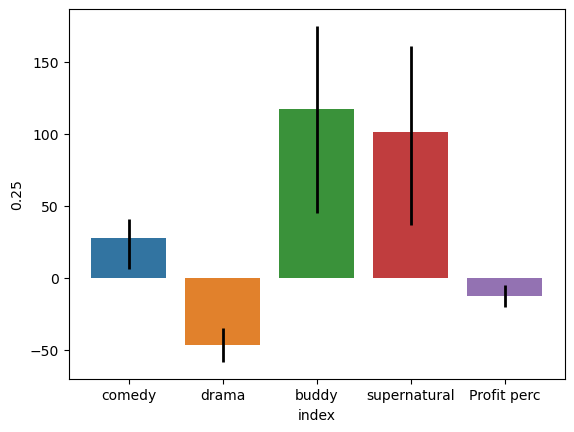

In [176]:
ax = sns.barplot(data=mid_df_profit_perc[mid_genres_trust + ['Profit perc']].quantile(0.25).to_frame().reset_index(),
            errorbar=None, x='index', y=0.25)

for n in range(len(mid_q1_conf[0])):
    ax.vlines(x=n,
            ymin=mid_q1_conf[1][n], ymax=mid_q1_conf[2][n],
            linewidth=2, color='black');

In [177]:
mid_q3_conf = get_conf_df(mid_df_profit_perc, mid_genres_trust + ['Profit perc'], my_q3)

In [178]:
mid_q3_conf_df = pd.DataFrame(index=mid_q3_conf[0], data={'Low band':mid_q3_conf[1],
            'High band':mid_q3_conf[2]})

mask1 = mid_q3_conf_df.loc[:,'Low band'] > mid_q3_conf_df.loc['Profit perc', 'High band']
mask2 = mid_q3_conf_df.loc[:,'High band'] < mid_q3_conf_df.loc['Profit perc', 'Low band']

mid_q3_conf_df[(mask1 | mask2)]

,Low band,High band
drama,90.3333,162.6416
buddy,251.9359,423.6146
supernatural,203.4773,421.7391


#### In this case, the q3 for comedy genre does overlap the q3 for all the genres. So we can't say that the comedy does influece the profit %

c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


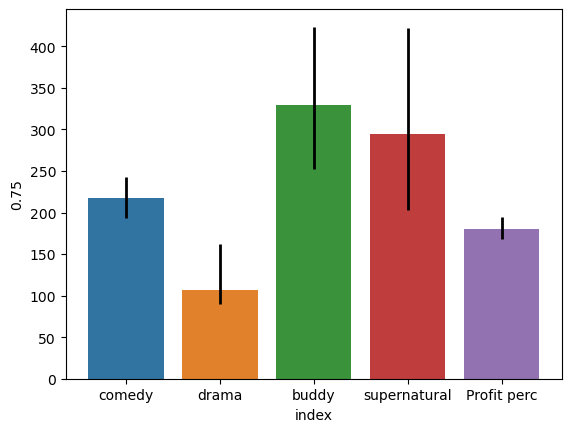

In [179]:
ax = sns.barplot(data=mid_df_profit_perc[mid_genres_trust + ['Profit perc']].quantile(0.75).to_frame().reset_index(),
            errorbar=None, x='index', y=0.75)

for n in range(len(mid_q3_conf[0])):
    ax.vlines(x=n,
            ymin=mid_q3_conf[1][n], ymax=mid_q3_conf[2][n],
            linewidth=2, color='black');